### Importing analysis packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import dabest as db
import pathlib as plb
from scipy.stats import norm
import statistics

### Reading in and cleaning up the data

In [2]:
### Read in data that contains unblinded compounds, chemotaxis indices and worm totals
### for the March 2021 screen.

screen_data = pd.read_csv('C:/Users/Emily/Documents/_2021_03_screen/2103_ia_results_unblinded.csv', index_col=0)


In [3]:
#Creating a subset of the 03/2021 data that contains only values for DMSO:DMSO
subset =  screen_data.loc[screen_data['Compound Name']== 'DMSO']

#Generating a file path to dynamically read in worm location files
wrm_locs_fldr = plb.Path('C:/Users/Emily/Documents/_2021_03_screen/_2021_03_automated_results/')

In [4]:
# A function that will aggregate the all worm locations for a given condition

def get_worm_locs(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound Name']
    xs = temp['centroid-1']
    #xs = list(temp['centroid-1'])
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict


In [5]:
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in subset.iterrows():
    pooled_refs = get_worm_locs(row, wrm_locs_fldr, results_dict)

#Casting dict to df. The algorithm will be resampling from 747 data points (worm locations) 
pooled_refs_df = pd.DataFrame.from_dict(pooled_refs)
pooled_refs_df.head()

,DMSO
0,568
1,1803
2,792
3,2215
4,1089


#### Generating a swarm plot of worm locations relative to DMSO

In [6]:
for_swarm = pooled_refs_df.copy()
for_swarm['Compound'] = 'DMSO'
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm

av_width = 3053.2
middle = (av_width/2)/px_mm
print(middle)
#for_swarm['DMSO'] = pooled_refs_df['DMSO'].apply(lambda x: x/px_mm)
#The following transforms the worm location data so that it is respective to the start zone
# The start zone is at the center of the image; Start Zone = 0mm
#Worms with positive values are closer to the compound, negative values are away from the compound

for_swarm['DMSO'] = pooled_refs_df['DMSO'].apply(lambda x: -(x/px_mm)+middle)


32.31303333333333


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


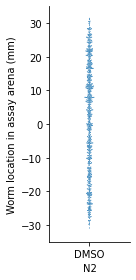

In [7]:
#for_swarm = pooled_refs_df.copy()
#for_swarm['Compound'] = 'DMSO'
fig, ax = plt.subplots(figsize=(2,4))
ax = sns.swarmplot('Compound', 'DMSO', data=for_swarm, size=1)
ax.set_ylim(-35,35)
ax.set(xlabel="N2", ylabel="Worm location in assay arena (mm)")
sns.despine()
fig.tight_layout()
#plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/dmso_swarm.png', dpi=300)

### Bootstrapping steps
1. Randomly sample groups of 50, 100, 150 ... 300, 350 worms -> hold in an array
2. Calculate chemotaxis index for each group of worms
3. Iterate random sampling and CI calculation 100 times -> Hold CIs in an array
4. Plot

In [8]:
# Creating a np array of all worm locations from 2103 dataset to be used for resampling
x_dmso = np.asarray(pooled_refs_df['DMSO'])
# Generating sample pools of varying sizes
sample_sizes = [50, 100, 150, 200, 250, 300, 350]
# Resampling each sample size 100x
n = 100

In [9]:
# We need to generate a function to calculate the chemotaxis indices for each bootstrapped sample. The chemotaxis index
# will be used to assess where the variance for the model levels off

def calc_chemotaxis_index(worms):
    
    ## Assign features to zones of the plate
    left_area_boundary = int(4/9*3053) #Need to generate a more accurate boundary value
    #print(left_area_boundary)
    right_area_boundary = int(5/9*3053) #Need to generate a more accurate boundary value
    #print(right_area_boundary)

    left_side_worms = worms[worms['X'] <= left_area_boundary]
    #middle_w = worms[worms['centroid-1'] < right_area_boundary]
    #middle_worms = middle_w[middle_w['centroid-1'] >left_area_boundary]
    right_side_worms = worms[worms['X'] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    #worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(right_side_worms) + len(left_side_worms)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))

    

    try:
        chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
        return chemotaxis_index

    except ZeroDivisionError:
        return 0
    

### The following will generate a wide dataframe of the bootstrapped values
<p> The dfferent plotting approaches below require different dataframe formats (wide vs long). We create functions to generate both </p>

In [10]:
CI_df = pd.DataFrame(columns=sample_sizes)
np.random.seed(12345)
for j in sample_sizes:
    CIs = []
    #for n in sample_sizes:
    i=0
    while i < 100:

        resample = np.random.choice(a=x_dmso, size=j, replace=True)
        resample_df = pd.DataFrame(resample, columns=['X'])
        CI = calc_chemotaxis_index(resample_df)
        CIs.append(CI)
        i += 1
    CI_df[j]= CIs
    #print(len(CIs))
CI_df.head()

,50,100,150,200,250,300,350
0,-0.095238,-0.010753,0.123077,0.233333,0.093333,0.153558,0.110390
1,0.121951,0.000000,0.093525,0.043956,0.190909,0.078652,0.173077
2,-0.021277,0.075269,0.085271,0.168539,0.194570,0.173432,0.100629
3,0.173913,0.195652,0.269841,0.057471,0.114155,0.181818,0.056604
4,0.090909,0.066667,-0.015152,0.166667,0.236364,0.088235,0.130719


### The following will generate a long dataframe

In [11]:
CI_df_long = pd.DataFrame(columns=['CI', 'N'])
np.random.seed(12345)
for j in sample_sizes:
    CIs = []
    #for n in sample_sizes:
    i=0
    while i < 100:
        
        resample = np.random.choice(a=x_dmso, size=j, replace=True)
        resample_df_long = pd.DataFrame(resample, columns=['X'])
        CI = (calc_chemotaxis_index(resample_df_long), j)
        CIs.append(CI)
        i += 1
    CI_df_long = CI_df_long.append(pd.DataFrame(CIs, columns=['CI', 'N']))


In [12]:
v = CI_df_long.groupby('N').agg(np.var).reset_index()
CI_df_long['N'] = CI_df_long.N.astype(int)

In [13]:
v = v.rename(columns = {'CI': 'N2'})
v

,N,N2
0,50,0.019136
1,100,0.012323
2,150,0.006562
3,200,0.005979
4,250,0.004587
5,300,0.004064
6,350,0.002957


### This is the version of the figure that is currently being used in the manuscript. The variance is plotted above the boxplots for each group.

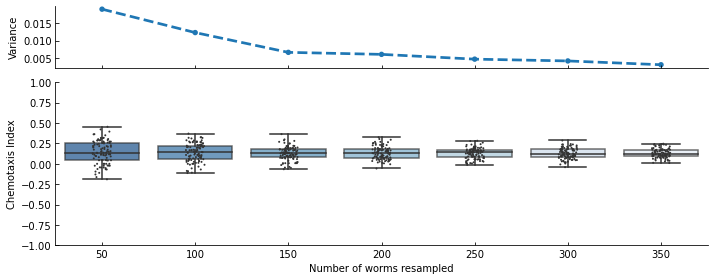

In [19]:
#sns.set(style="white")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True, gridspec_kw={'height_ratios': [.75, 2]})

axes[0] = sns.pointplot(x='N', y='N2', data=v, linestyle='--', ax=axes[0], markers='.')
axes[0].lines[0].set_linestyle("--")
axes[0].set(xlabel="", ylabel="Variance")
axes[0].tick_params(axis='both', tickdir='in')

axes[1] = sns.boxplot(x="N", y="CI", data=CI_df_long, whis=np.inf,
                   palette="Blues_r", boxprops=dict(alpha=.7), ax=axes[1])
axes[1] = sns.stripplot(x="N", y="CI", data=CI_df_long, size=2, color='.2', ax=axes[1])
axes[1].set(xlabel="Number of worms resampled", ylabel="Chemotaxis Index")
axes[1].tick_params(axis='both', tickdir='in')
axes[1].set_ylim(-1,1)

sns.despine()
plt.rcParams['svg.fonttype'] = 'none'
fig.tight_layout()
fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/Seeded_stackd_bstrap.svg', dpi=300)

### Below is the first interation of the bootstrapping plot with an inset of the variance of chemotaxis index for each group

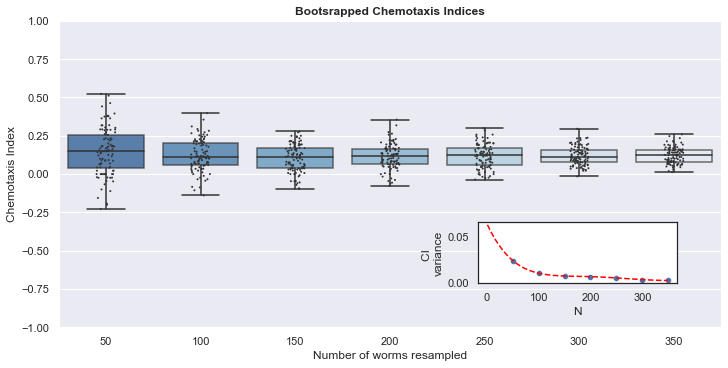

In [38]:

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), constrained_layout=True)
axes = sns.boxplot(x="N", y="CI", data=CI_df_long, whis=np.inf,
                   palette="Blues_r", boxprops=dict(alpha=.7),ax=axes)
axes = sns.stripplot(x="N", y="CI", data=CI_df_long, size=2, color='.2', ax=axes)
axes.set(xlabel="Number of worms resampled", ylabel="Chemotaxis Index", ylim=(-1,1))
axes.set_title('Bootsrapped Chemotaxis Indices', weight='bold')

sns.set_style('white')
axins = inset_axes(axes,  "30%", "20%" ,loc="lower right", borderpad=4)
    
model5 = np.poly1d(np.polyfit(v.N, v.CI, 5))

#define scatterplot
polyline = np.linspace(1, 350, 50)
sns.scatterplot(x= v.N, y=v.CI, ax=axins)
axins.set(xlabel='N', ylabel='CI \nvariance')

#add fitted polynomial curve to scatterplot
plt.plot(polyline, model5(polyline), '--', color='red')

#plt.savefig('D:/NP_manuscript/figs/1D_bootstrap.png')

In [123]:
(25.4/1200)*3250

68.79166666666667